In [25]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [27]:
import os

os.chdir("/home/zkx/Pytorch")

In [28]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

In [4]:
# data_train = datasets.MNIST(root="./data/mnist", transform=transform, train=True)
# data_test = datasets.MNIST(root="./data/mnist", transform=transform, train=False)
#
# data_loader_train = DataLoader(data_train, batch_size=256, shuffle=True)
# data_loader_test = DataLoader(data_test, batch_size=128, shuffle=True)

In [29]:
data_train = datasets.CIFAR10(root="./data/", transform=transform, train=True, download=True)
data_test = datasets.CIFAR10(root="./data/", transform=transform, train=False, download=True)

data_loader_train = DataLoader(data_train, batch_size=256, shuffle=True)
data_loader_test = DataLoader(data_test, batch_size=128, shuffle=True)

100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data/
Files already downloaded and verified


In [55]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1),
                                   nn.ReLU(),
                                   nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
                                   nn.ReLU(),
                                   nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
                                   nn.ReLU(),
                                   nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
                                   nn.ReLU(),
                                   nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
                                   nn.ReLU(),
                                   nn.MaxPool2d(stride=2, kernel_size=2))
        self.dense = nn.Sequential(nn.Linear(16*16*128, 1024),
                                   nn.ReLU(),
                                   nn.Dropout(p=0.5),
                                   nn.Linear(1024, 10))
    def forward(self, x):
        x = self.conv1(x)
        x = x.view(-1, 16*16*128)
        x = self.dense(x)
        return x

In [56]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Model().to(device)

In [58]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
EPOCHS = 30

In [59]:
train_loss = [0] * EPOCHS
train_accuracy = [0] * EPOCHS
test_accuracy = [0] * EPOCHS
for epoch in range(EPOCHS):
    running_loss = 0.0
    running_acc = 0.0
    print(f"{epoch+1}/{EPOCHS}")
    for train_data, train_label in data_loader_train:
        train_data = train_data.to(device)
        train_label = train_label.to(device)
        outputs = model(train_data)
        _, pred = torch.max(outputs, 1)
        loss = criterion(outputs, train_label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_acc += torch.sum(pred == train_label).item()

    train_loss[epoch] = running_loss
    train_accuracy[epoch] = running_acc / len(data_train)

    test_acc = 0.0
    for test_data, test_label in data_loader_test:
        test_data = test_data.to(device)
        test_label = test_label.to(device)
        outputs = model(test_data)
        _, pred = torch.max(outputs, 1)
        test_acc += torch.sum(pred == test_label).item()
    test_accuracy[epoch] = test_acc / len(data_test)
    print(f"Loss is {train_loss[epoch]:.4f}, Train Acc is {100*train_accuracy[epoch]:.4f}, Test Acc is {100*test_accuracy[epoch]:.4f}")

1/30
Loss is 325.7352, Train Acc is 39.5400, Test Acc is 48.8300
2/30
Loss is 234.9810, Train Acc is 57.1520, Test Acc is 61.1400
3/30
Loss is 188.9365, Train Acc is 65.9040, Test Acc is 66.2900
4/30
Loss is 154.0120, Train Acc is 72.4500, Test Acc is 68.5800
5/30
Loss is 124.7065, Train Acc is 77.4260, Test Acc is 67.7600
6/30
Loss is 99.9414, Train Acc is 81.9900, Test Acc is 70.6600
7/30
Loss is 74.4352, Train Acc is 86.6000, Test Acc is 70.7000
8/30
Loss is 56.8647, Train Acc is 89.7680, Test Acc is 69.4500
9/30
Loss is 43.1652, Train Acc is 92.3480, Test Acc is 70.1600
10/30
Loss is 37.4802, Train Acc is 93.2960, Test Acc is 69.1100
11/30
Loss is 28.8480, Train Acc is 94.9080, Test Acc is 70.7000
12/30
Loss is 25.2084, Train Acc is 95.5080, Test Acc is 70.0800
13/30
Loss is 22.0338, Train Acc is 96.0680, Test Acc is 69.9600
14/30
Loss is 20.9881, Train Acc is 96.4200, Test Acc is 70.1200
15/30
Loss is 19.9915, Train Acc is 96.4840, Test Acc is 69.8900
16/30
Loss is 18.0880, Train 

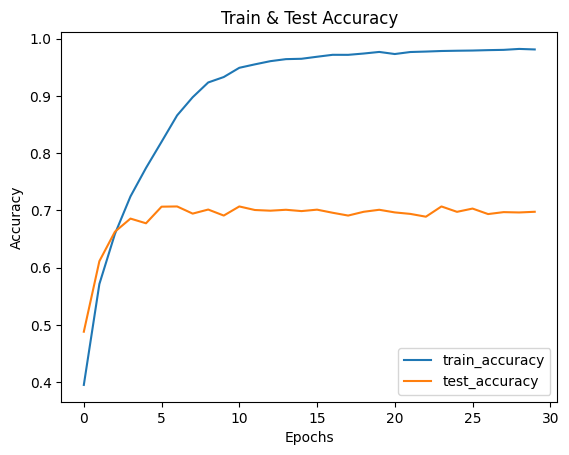

In [63]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.title("Train & Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(train_accuracy, label="train_accuracy")
plt.plot(test_accuracy, label="test_accuracy")
plt.legend()
plt.show()

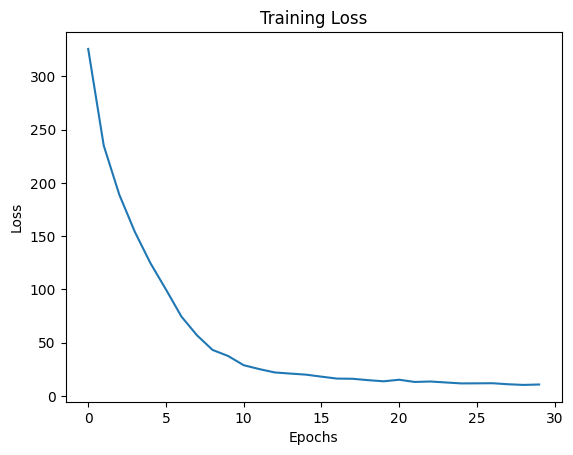

In [64]:
plt.plot(train_loss)
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()